In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
import os
from data_fonemas import *
from scipy.interpolate import interp1d
from IPython.display import Audio, display
# from data_fonemas import coef_a, coef_b
# from scipy.signal import lfilter
# from data_fonemas import suavizar_bordes, gen_pulsos, coef_a, coef_b

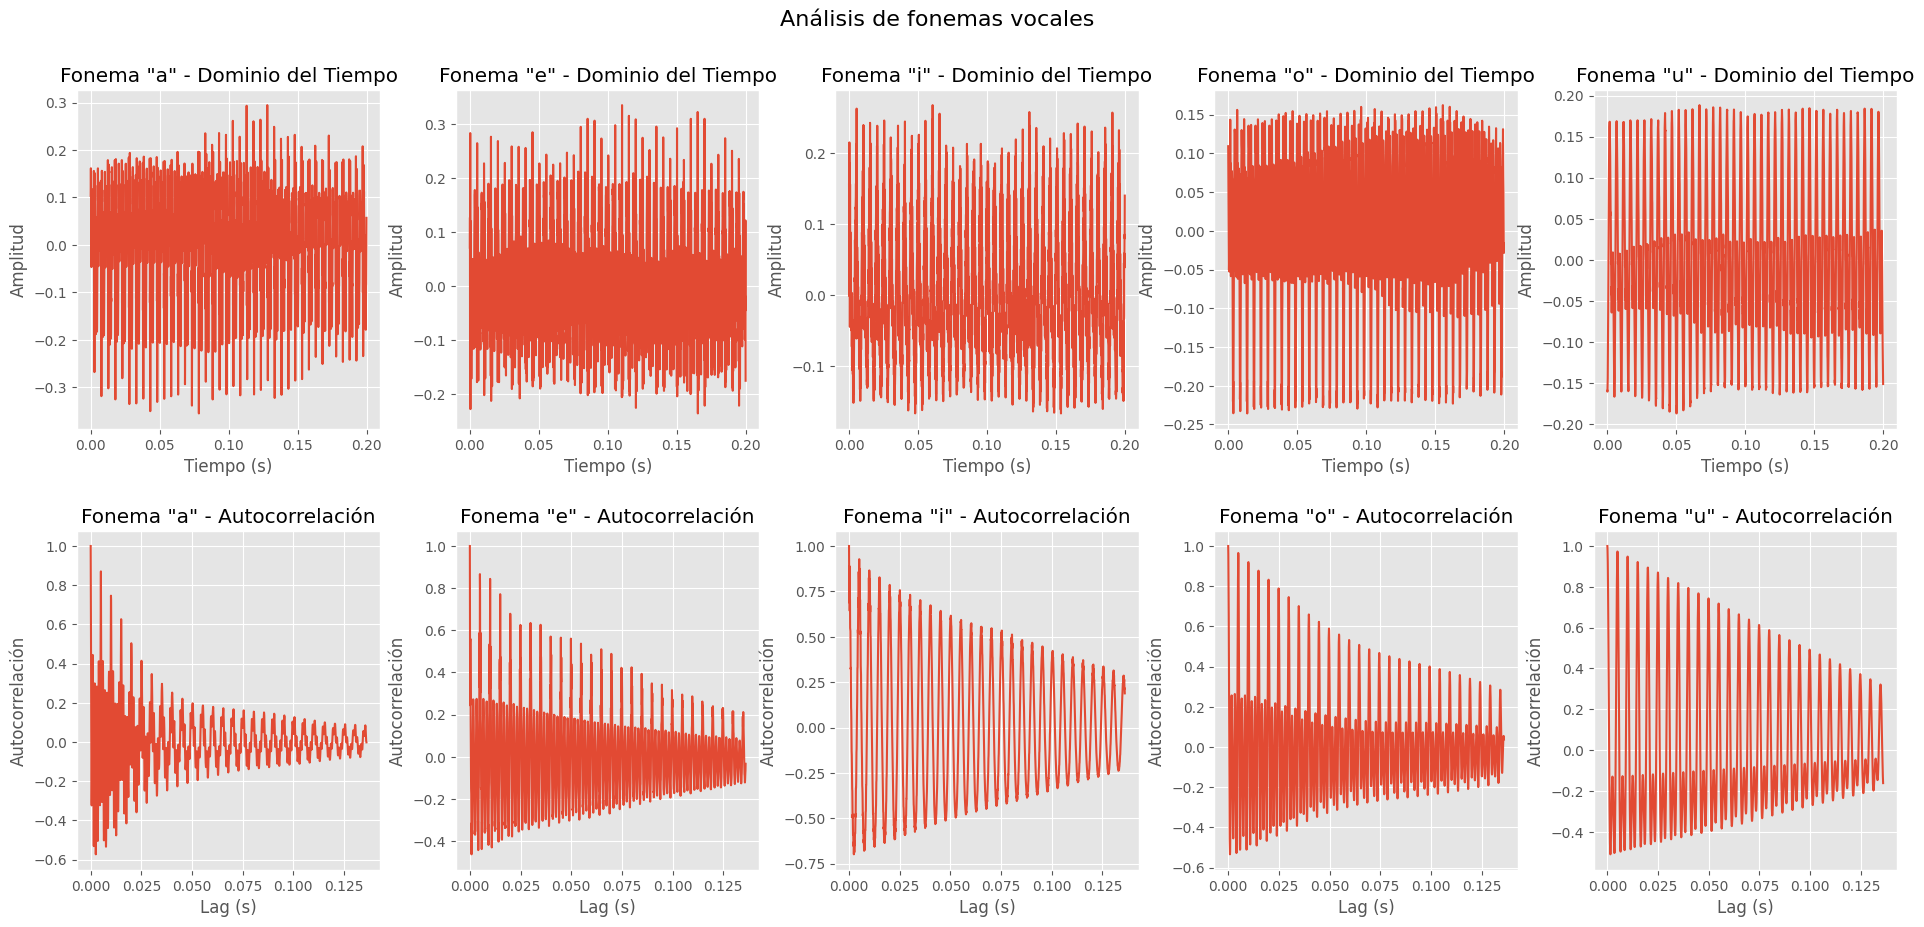

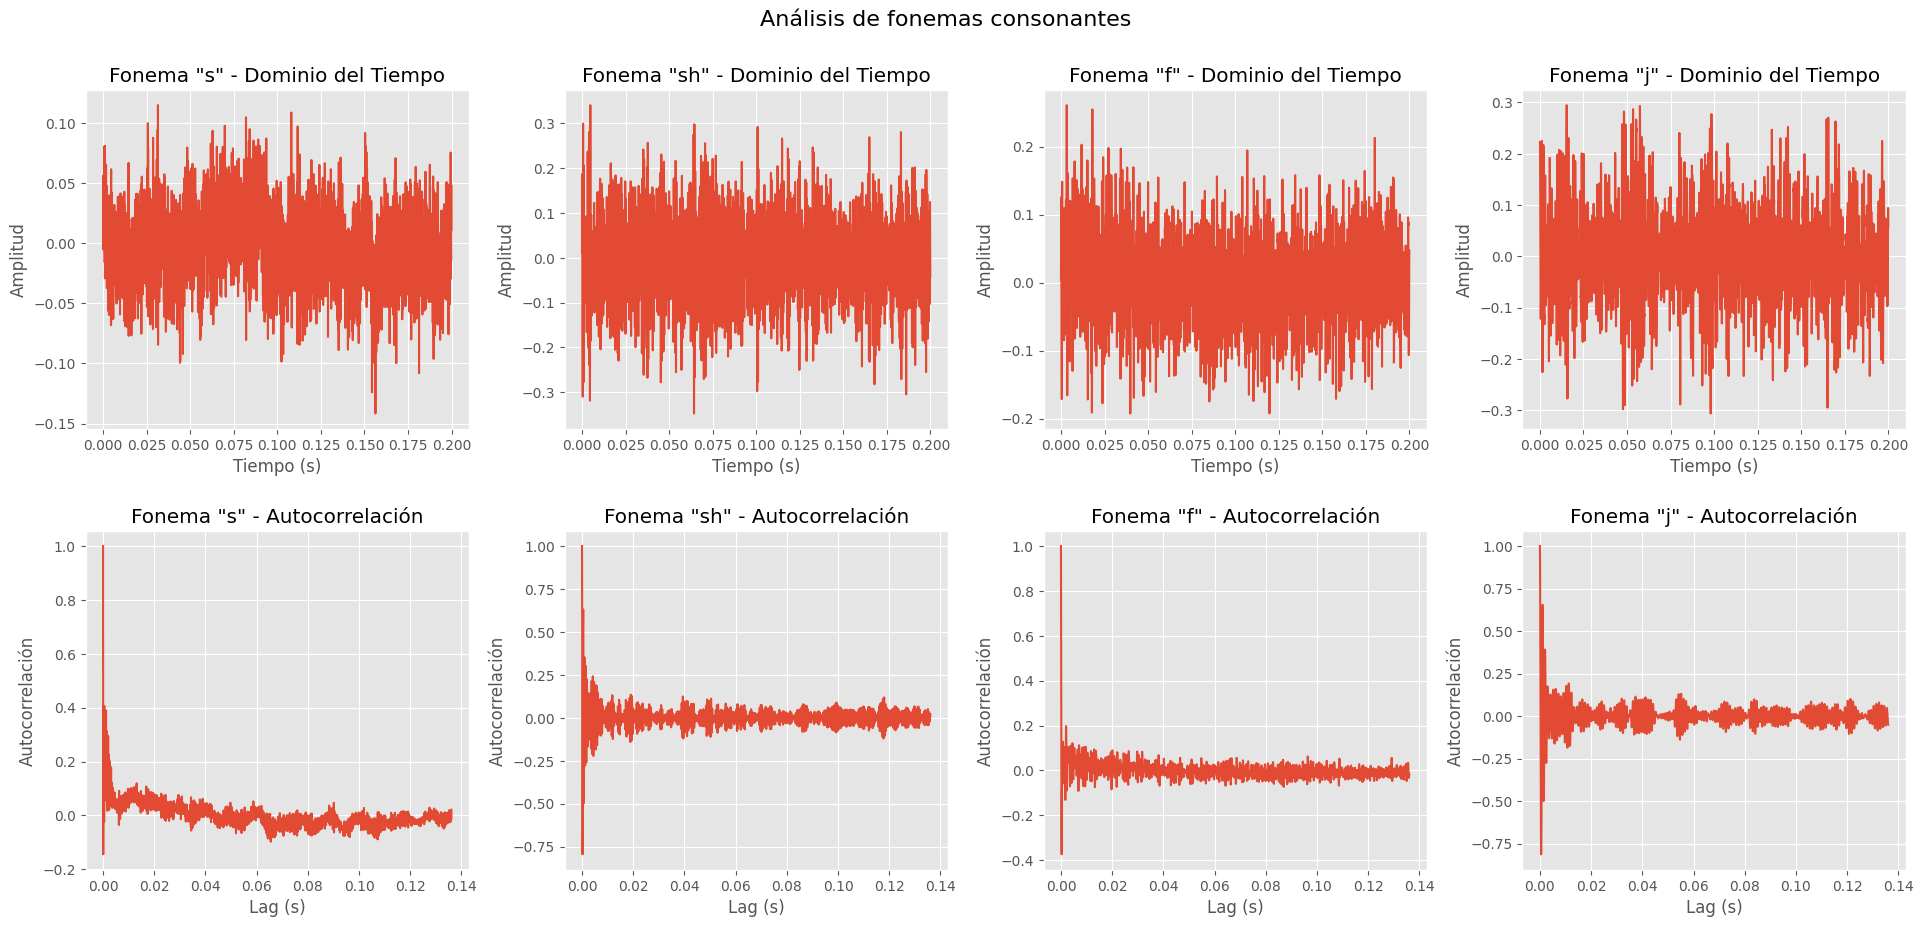

In [40]:
# Ejercicio 1: Análisis del modelo
# a.

plt.rcParams['figure.figsize'] = (14, 8)
plt.style.use('ggplot')

audio_path = "./audios/"

vocales = ['a', 'e', 'i', 'o', 'u']
consonantes = ['s', 'sh', 'f', 'j']
fonemas = vocales + consonantes

def autocorrelacion(x, lagmax=None):
    n = len(x)
    if lagmax is None:
        lagmax = n
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')
    r = r[n-1:n+lagmax]
    return r / r[0]

fig_vocales, axs_vocales = plt.subplots(2, len(vocales), figsize=(20, 10))
fig_vocales.suptitle('Análisis de fonemas vocales', fontsize=16)

fig_consonantes, axs_consonantes = plt.subplots(2, len(consonantes), figsize=(20, 10))
fig_consonantes.suptitle('Análisis de fonemas consonantes', fontsize=16)

tiempo = 0.2  # 200ms duración de la muestra

for i, fonema in enumerate(fonemas):
    filename = f"{audio_path}{fonema}.wav"
    try:
        audio, fs = sf.read(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        continue
    
    mitad_del_audio = len(audio) // 2
    samples = int(tiempo * fs)
    segmento = audio[mitad_del_audio - samples//2:mitad_del_audio + samples//2]
    
    t = np.arange(len(segmento)) / fs
    
    # autocorrelación
    acorr = autocorrelacion(segmento, lagmax=min(2000, len(segmento)))
    lag_time = np.arange(len(acorr)) / fs
    
    if fonema in vocales:
        ax_time = axs_vocales[0, vocales.index(fonema)]
        ax_acorr = axs_vocales[1, vocales.index(fonema)]
    else:
        ax_time = axs_consonantes[0, consonantes.index(fonema)]
        ax_acorr = axs_consonantes[1, consonantes.index(fonema)]
    
    ax_time.plot(t, segmento)
    ax_time.set_title(f'Fonema "{fonema}" - Dominio del Tiempo')
    ax_time.set_xlabel('Tiempo (s)')
    ax_time.set_ylabel('Amplitud')
    
    ax_acorr.plot(lag_time, acorr)
    ax_acorr.set_title(f'Fonema "{fonema}" - Autocorrelación')
    ax_acorr.set_xlabel('Lag (s)')
    ax_acorr.set_ylabel('Autocorrelación')

plt.tight_layout()
fig_vocales.subplots_adjust(top=0.9, bottom=0.12, left=0.07, right=0.98, hspace=0.3, wspace=0.25)
fig_consonantes.subplots_adjust(top=0.9, bottom=0.12, left=0.07, right=0.98, hspace=0.3, wspace=0.25)
plt.show()

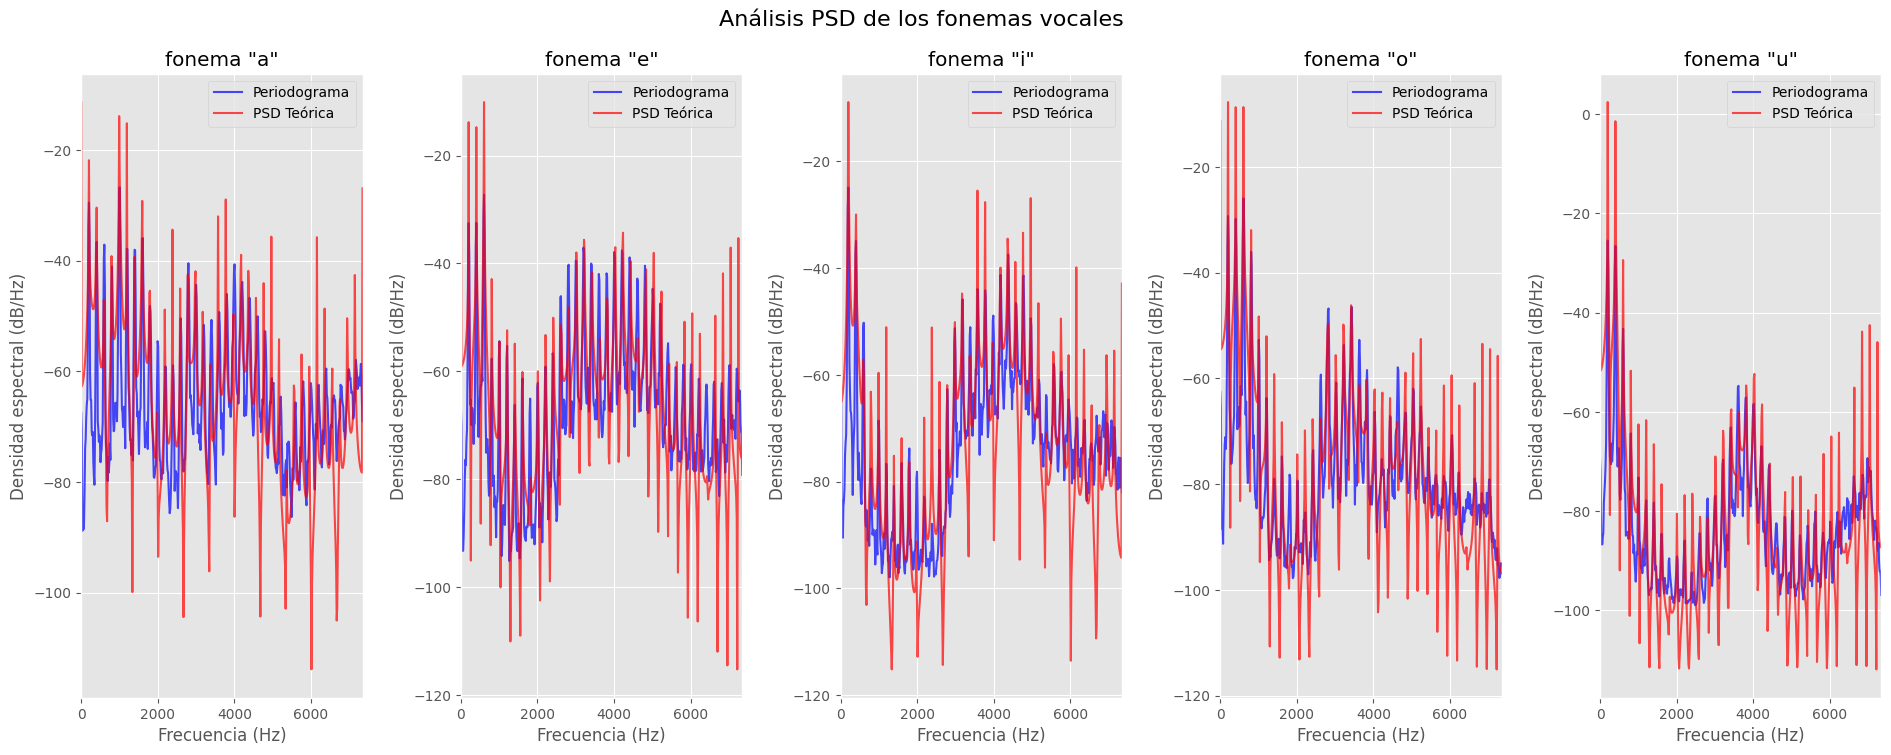

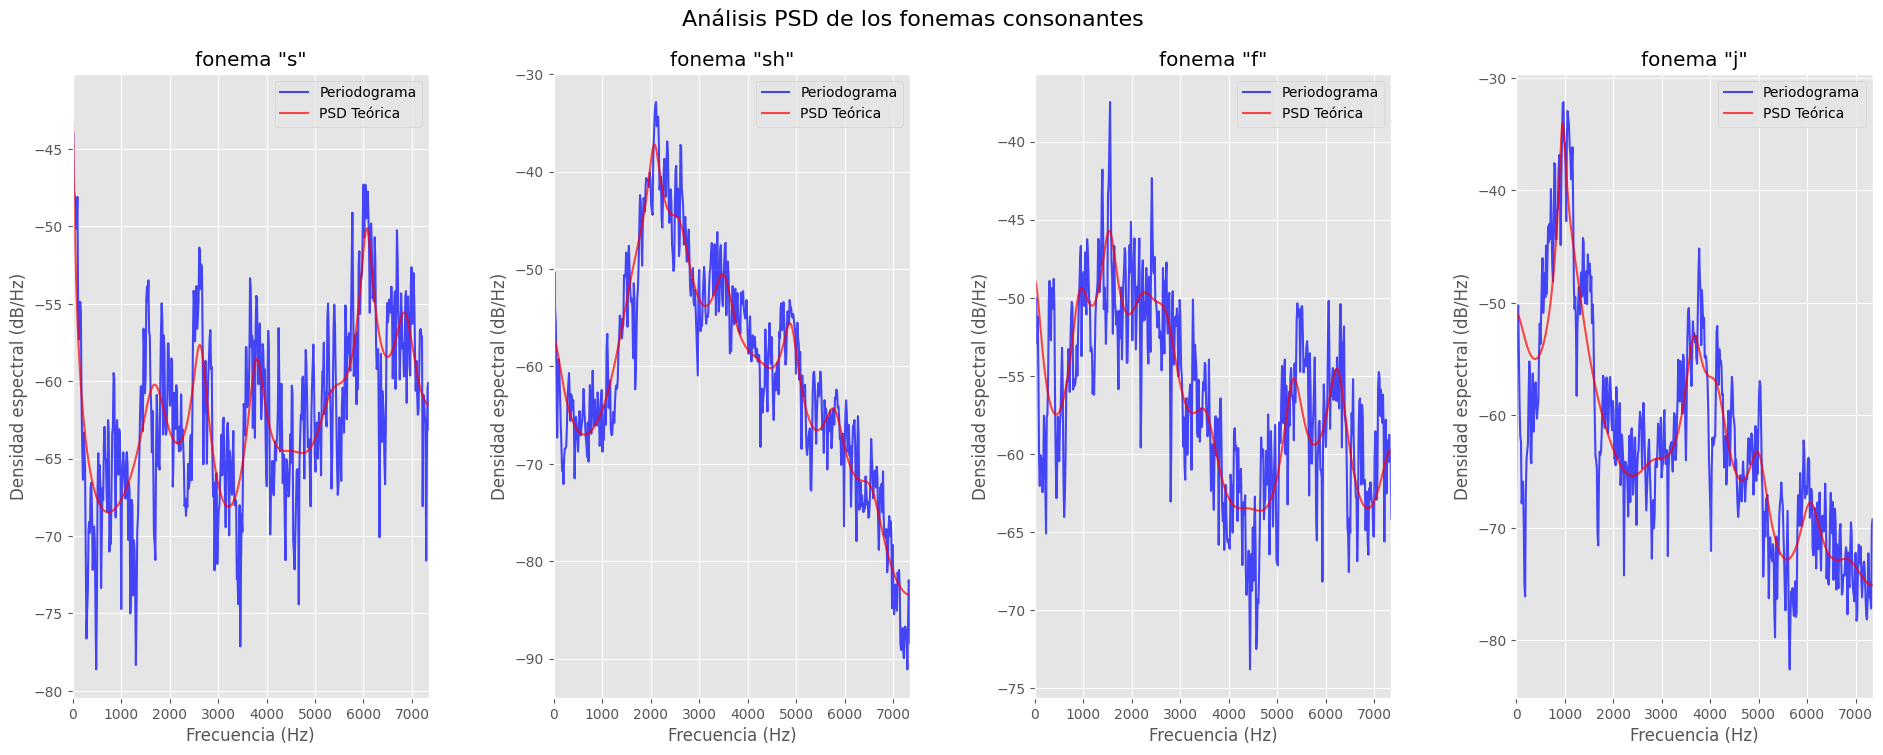

In [ ]:
# Ejercicio 1: Análisis de fonemas
# b.

fs = 14700

# PSD Teórica
def psd_teo(a_coef, b_coef, f, fs, fonema_type='consonante', tono=None):
    b_scalar = b_coef[0]
    w = 2 * np.pi * f / fs
    _, h = signal.freqz([b_scalar], np.concatenate(([1.0], -np.array(a_coef))), w)
    
    if fonema_type == 'consonante':
        S_X = np.abs(h)**2
    else:
        N = 8192
        pulso_psd, pulso_freqs = psd_pulsos(tono, N, fs)
        func_interpol = interp1d(pulso_freqs, pulso_psd, kind='linear', bounds_error=False, fill_value=0)
        S_U = func_interpol(f)
        S_X = np.abs(h)**2 * S_U
    return S_X

fig_psd_vocales, axs_psd_vocales = plt.subplots(1, len(vocales), figsize=(20, 8))
fig_psd_vocales.suptitle('Análisis PSD de los fonemas vocales', fontsize=16)

fig_psd_consonantes, axs_psd_consonantes = plt.subplots(1, len(consonantes), figsize=(20, 8))
fig_psd_consonantes.suptitle('Análisis PSD de los fonemas consonantes', fontsize=16)

tiempo = 0.2

for fonema in fonemas:
    filename = f"{audio_path}{fonema}.wav"
    audio, fs = sf.read(filename)
    
    mitad_del_audio = len(audio) // 2
    samples = int(tiempo * fs)
    segmento = audio[mitad_del_audio - samples//2:mitad_del_audio + samples//2]
    
    window = np.hanning(len(segmento))
    windowed_segmento = segmento * window
    
    f_welch, Pxx_welch = signal.welch(windowed_segmento, fs=fs, nperseg=1024, noverlap=512, scaling='spectrum')
    
    Pxx_db = 10 * np.log10(Pxx_welch + 1e-10)
    
    a_coefs = coef_a[fonema]
    b_coef = coef_b[fonema]
    
    if fonema in vocales:
        acorr = autocorrelacion(segmento, lagmax=min(2000, len(segmento)))
        exclude_samples = 20
        peak_idx = exclude_samples + np.argmax(acorr[exclude_samples:min(1000, len(acorr))])
        tono_estimado = fs / peak_idx if peak_idx > 0 else 100
        
        S_X_teo = psd_teo(a_coefs, b_coef, f_welch, fs, fonema_type='vocal', tono=tono_estimado)
    else:
        S_X_teo = psd_teo(a_coefs, b_coef, f_welch, fs, fonema_type='consonante')
    
    S_X_teo_db = 10 * np.log10(S_X_teo + 1e-10)
    
    scale_factor = np.mean(Pxx_db) - np.mean(S_X_teo_db)
    S_X_teo_db += scale_factor
    
    if fonema in vocales:
        ax = axs_psd_vocales[vocales.index(fonema)]
    else:
        ax = axs_psd_consonantes[consonantes.index(fonema)]
    
    ax.plot(f_welch, Pxx_db, 'b-', alpha=0.7, label='Periodograma')
    ax.plot(f_welch, S_X_teo_db, 'r-', alpha=0.7, label='PSD Teórica')
    
    ax.set_xlim(0, fs/2)
    
    ax.set_title(f'fonema "{fonema}"')
    ax.set_xlabel('Frecuencia (Hz)')
    ax.set_ylabel('Densidad espectral (dB/Hz)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
fig_psd_vocales.subplots_adjust(top=0.9, bottom=0.12, left=0.08, right=0.98, wspace=0.35)
fig_psd_consonantes.subplots_adjust(top=0.9, bottom=0.12, left=0.08, right=0.98, wspace=0.35)
plt.show()

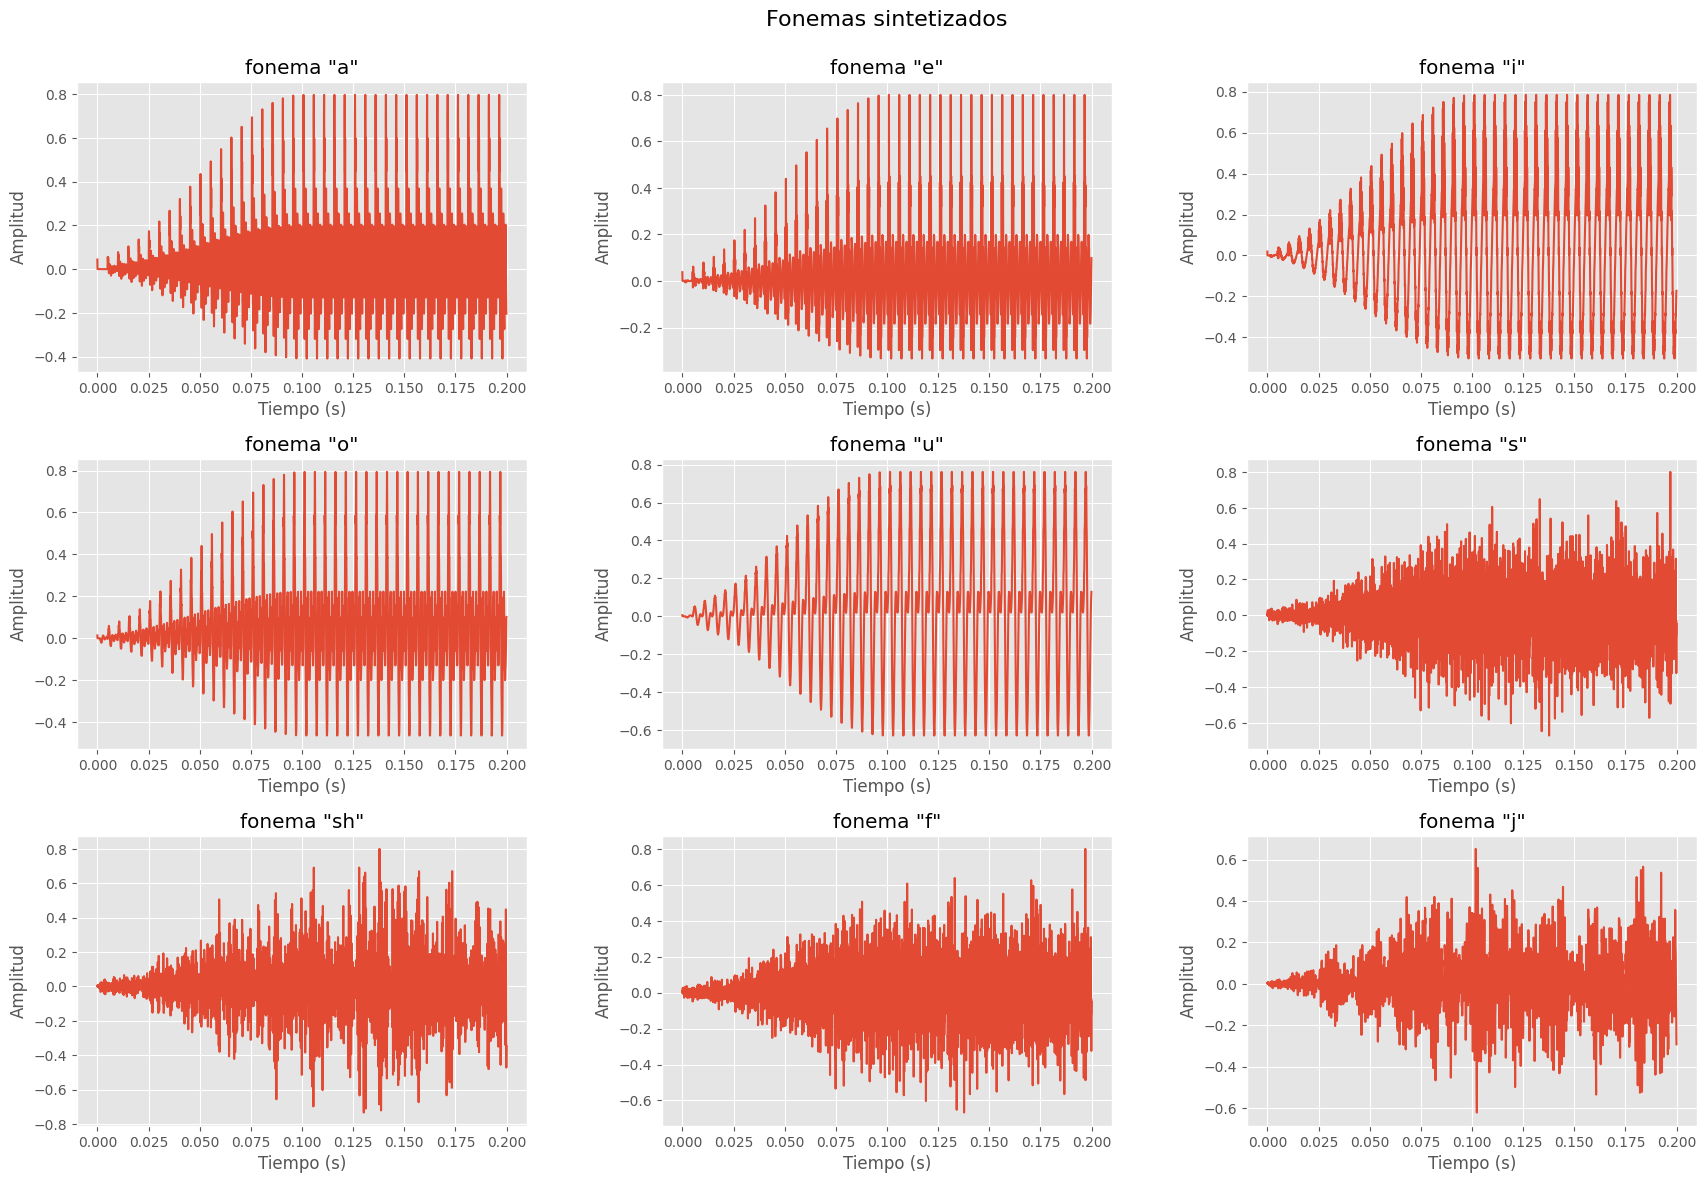

In [47]:
# Ejercicio 2: sintetización de fonemas
# a

fs = 14700
tiempo = 0.5
N = int(fs * tiempo)
f0 = 200

fonemas_sintetizados = {}

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Fonemas sintetizados', fontsize=16)
axs = axs.flatten()

for i, fonema in enumerate(fonemas):
    # Coeficientes AR
    coef_afs = coef_a[fonema]
    coef_bf = coef_b[fonema][0]
    
    # Señal de excitación
    if fonema in vocales:
        excitation = gen_pulsos(f0, N, fs) # Tren de pulsos
    else:
        np.random.seed(42)
        excitation = np.random.randn(N) # Ruido blanco
    
    # Solución para las señales s y f que daban problemas
    if fonema in ['s', 'f']:
        nfft = 512
        w, h = signal.freqz([coef_bf], [1.0] + coef_afs, worN=nfft)

        np.random.seed(42)
        noise = np.random.randn(N)
        
        ruido_fft = np.fft.rfft(noise)
        freq_bins = min(len(ruido_fft), nfft//2+1)
        
        from scipy.interpolate import interp1d
        f_normalizado = w / np.pi
        respuesta_mag = np.abs(h)
        
        indices_validos = ~np.isnan(respuesta_mag) & ~np.isinf(respuesta_mag)
        if np.sum(indices_validos) > 1:
            f_valid = f_normalizado[indices_validos]
            mag_valid = respuesta_mag[indices_validos]
            
            func_interpol = interp1d(f_valid, mag_valid, bounds_error=False, fill_value=(mag_valid[0], mag_valid[-1]))
    
            target_freqs = np.linspace(0, 1, freq_bins)
            filter_shape = func_interpol(target_freqs)
            filter_shape = np.clip(filter_shape, 0, 10)
            ruido_fft[:freq_bins] *= filter_shape
            sintetizado = np.fft.irfft(ruido_fft, n=N)
        else:
            sintetizado = signal.lfilter([coef_bf], [1.0], noise)
            
        sintetizado = sintetizado / (np.max(np.abs(sintetizado)) + 1e-10) * 0.8 # Normalizo   
    else:
        a_full = np.concatenate(([1.0], coef_afs))
        sintetizado = signal.lfilter([coef_bf], a_full, excitation)
        
        if not np.all(np.isfinite(sintetizado)):
            sintetizado = np.zeros(N)
            for n in range(min(20, N)):
                sintetizado[n] = coef_bf * excitation[n]
            
            for n in range(20, N):
                sintetizado[n] = coef_bf * excitation[n]
                for j, a in enumerate(coef_afs):
                    if n-j-1 >= 0:
                        sintetizado[n] += a * sintetizado[n-j-1]
                sintetizado[n] = np.clip(sintetizado[n], -100, 100)
        
        if np.max(np.abs(sintetizado)) > 0:
            sintetizado = 0.8 * sintetizado / np.max(np.abs(sintetizado))
                
    sintetizado = suavizar_bordes(sintetizado, fade=20)
    fonemas_sintetizados[fonema] = sintetizado
    data = sintetizado[:int(0.2*fs)]
        
    display_samples = int(0.2 * fs)
    t = np.arange(display_samples) / fs
    
    axs[i].plot(t, data)
    axs[i].set_title(f'fonema "{fonema}"')
    axs[i].set_xlabel('Tiempo (s)')
    axs[i].set_ylabel('Amplitud')
    axs[i].grid(True)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.92, wspace=0.3, hspace=0.3)
plt.show()

output_dir = "./fonemas_sintetizados/"
os.makedirs(output_dir, exist_ok=True)

for fonema, audio in fonemas_sintetizados.items():
    valid_audio = np.nan_to_num(audio, nan=0.0, posinf=0.0, neginf=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)
    sf.write(f"{output_dir}Ej2a_{fonema}_sintetizado.wav", valid_audio, fs)


In [ ]:
# Ejercicio 2: sintetización de fonemas
# b

fs = 14700
secuencia_de_fonemas = vocales + consonantes  # ['a', 'e', 'i', 'o', 'u', 's', 'sh', 'f', 'j']

tiempo_de_silencio = 0.15
silencio = np.zeros(int(tiempo_de_silencio * fs))
señal_concatenada = []

for i, fonema in enumerate(secuencia_de_fonemas):
    audio_fonema = fonemas_sintetizados[fonema]
    valid_audio = np.nan_to_num(audio_fonema, nan=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)
    señal_concatenada.extend(valid_audio)
    if i < len(secuencia_de_fonemas) - 1:
        señal_concatenada.extend(silencio)

señal_concatenada = np.array(señal_concatenada)

max_amp = np.max(np.abs(señal_concatenada))
if max_amp > 0:
    señal_concatenada = 0.9 * señal_concatenada / max_amp

concatenated_filename = f"{output_dir}Ej2b_fonemas_concatenados.wav"
sf.write(concatenated_filename, señal_concatenada, fs)

display(Audio(señal_concatenada, rate=fs))


In [59]:
# Ejercicio 2: sintetización de fonemas
# c
fs = 14700
tiempo = 0.5
N = int(fs * tiempo)

dict_de_tonos = {'a': 100, 'e': 125, 'i': 150, 'o': 125, 'u': 100}

def filtro_butter_bandpass(data, lowcut, highcut, fs, orden=4):
    nyquist = 0.5 * fs
    lowcut = min(lowcut, 0.98 * nyquist)
    highcut = min(highcut, 0.98 * nyquist)
    low = lowcut / nyquist
    high = highcut / nyquist
    if high <= low:
        high = min(0.98, low + 0.1)
    b, a = signal.butter(orden, [low, high], btype='band')
    y = signal.lfilter(b, a, data)
    return y

fonemas_sintetizados = {}

for i, fonema in enumerate(fonemas):
    coef_afs = coef_a[fonema]
    coef_bf = coef_b[fonema][0]
    if fonema in vocales:
        f0 = dict_de_tonos[fonema]
        excitation = gen_pulsos(f0, N, fs)
    else:
        np.random.seed(42)
        excitation = np.random.randn(N)
    if fonema == 's':
        sintetizado = filtro_butter_bandpass(excitation, 3500, 7000, fs)
        mid_freq_component = filtro_butter_bandpass(excitation, 1500, 3000, fs) * 0.3
        sintetizado += mid_freq_component
    elif fonema == 'f':
        sintetizado = filtro_butter_bandpass(excitation, 1500, 6000, fs)
        formant1 = filtro_butter_bandpass(excitation, 1000, 1500, fs) * 0.6
        formant2 = filtro_butter_bandpass(excitation, 3000, 5000, fs) * 0.7
        sintetizado = 0.5*sintetizado + formant1 + formant2
    else:
        a_full = np.concatenate(([1.0], coef_afs))
        sintetizado = signal.lfilter([coef_bf], a_full, excitation)
        if not np.all(np.isfinite(sintetizado)):
            if fonema in vocales:
                f1 = {'a': 800, 'e': 400, 'i': 300, 'o': 450, 'u': 325}[fonema]
                f2 = {'a': 1200, 'e': 2000, 'i': 2300, 'o': 800, 'u': 700}[fonema]
                bw1 = f1 * 0.1
                bw2 = f2 * 0.1
                sintetizado = signal.lfilter([1.0], [1.0, -0.9], excitation)
                q1 = int(fs / f1)
                q2 = int(fs / f2)
                resonador1 = np.zeros(N)
                resonador2 = np.zeros(N)
                for n in range(q1, N):
                    resonador1[n] = 0.9 * resonador1[n-q1] + excitation[n]
                for n in range(q2, N):
                    resonador2[n] = 0.8 * resonador2[n-q2] + excitation[n]
                sintetizado = 0.7 * resonador1 + 0.3 * resonador2
            else:
                sintetizado = filtro_butter_bandpass(excitation, 1000, 4000, fs)
    max_amp = np.max(np.abs(sintetizado))
    if max_amp > 0:
        sintetizado = 0.8 * sintetizado / max_amp
    sintetizado = suavizar_bordes(sintetizado, fade=20)
    fonemas_sintetizados[fonema] = sintetizado

output_dir = "./tono_variable/"
os.makedirs(output_dir, exist_ok=True)

for fonema, audio in fonemas_sintetizados.items():
    valid_audio = np.nan_to_num(audio, nan=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)
    sf.write(f"{output_dir}Ej2c_{fonema}_sintetizado.wav", valid_audio, fs)

secuencia_de_fonemas = vocales + consonantes
tiempo_de_silencio = 0.15
silencio = np.zeros(int(tiempo_de_silencio * fs))
señal_concatenada = []

for i, fonema in enumerate(secuencia_de_fonemas):
    fonema_audio = fonemas_sintetizados[fonema]
    valid_audio = np.nan_to_num(fonema_audio, nan=0.0)
    valid_audio = np.clip(valid_audio, -0.95, 0.95)
    señal_concatenada.extend(valid_audio)
    if i < len(secuencia_de_fonemas) - 1:
        señal_concatenada.extend(silencio)

señal_concatenada = np.array(señal_concatenada)
max_amp = np.max(np.abs(señal_concatenada))
if max_amp > 0:
    señal_concatenada = 0.9 * señal_concatenada / max_amp

concatenated_filename = f"{output_dir}Ej2_concatenado_con_diferentes_tonos.wav"
sf.write(concatenated_filename, señal_concatenada, fs)

display(Audio(señal_concatenada, rate=fs))

In [ ]:
secuencia_melodia_secreta = ['e','e','o','a','i','i','u','u','a','a','a','e','e','o','a','e','e','u','u','a','a','a','e','e','o','a','a','a','a','a','a','a','a','a','a','a','i','i','e','e','e','u']
tonos_melodia_secreta = {0:97.999,1:110,2:130.81,3:110,4:164.81,5:0.01,6:164.81,7:0.01,8:146.83,9:0.01,10:0.01,11:97.999,12:110,13:130.81,14:110,15:146.83,16:0.01,17:146.83,18:0.01,19:130.81,20:123.47,21:110,22:97.999,23:110,24:130.81,25:110,26:130.81,27:0.01,28:0.01,29:146.83,30:0.01,31:123.47,32:0.01,33:97.999,34:0.01,35:0.01,36:97.999,37:0.01,38:146.83,39:0.01,40:0.01,41:130.81}

duracion_silencio = 0.00
silencio = np.zeros(int(duracion_silencio * fs))
senal_concatenada = []

for i, fonema in enumerate(secuencia_melodia_secreta):
    if fonema in vocales:
        tono_melodia = tonos_melodia_secreta[i]        
        coef_a_fonema = coef_a[fonema]
        coef_b_fonema = coef_b[fonema][0]
        excitacion = gen_pulsos(tono_melodia, N, fs)
        a_completo = np.concatenate(([1.0], coef_a_fonema))
        sintetizado = signal.lfilter([coef_b_fonema], a_completo, excitacion)
        
        if not np.all(np.isfinite(sintetizado)):
            f1 = {'a': 800, 'e': 400, 'i': 300, 'o': 450, 'u': 325}[fonema]
            f2 = {'a': 1200, 'e': 2000, 'i': 2300, 'o': 800, 'u': 700}[fonema]
            
            sintetizado = signal.lfilter([1.0], [1.0, -0.9], excitacion)
            
            q1 = int(fs / f1)
            q2 = int(fs / f2)
            
            resonador1 = np.zeros(N)
            resonador2 = np.zeros(N)
            
            for n in range(q1, N):
                resonador1[n] = 0.9 * resonador1[n-q1] + excitacion[n]
                
            for n in range(q2, N):
                resonador2[n] = 0.8 * resonador2[n-q2] + excitacion[n]
                
            sintetizado = 0.7 * resonador1 + 0.3 * resonador2
        
        amplitud_max = np.max(np.abs(sintetizado))
        if amplitud_max > 0:
            sintetizado = 0.8 * sintetizado / amplitud_max
        
        muestra_audio = suavizar_bordes(sintetizado, fade=20)
    else:
        muestra_audio = fonemas_sintetizados[fonema]
    
    audio_valido = np.nan_to_num(muestra_audio, nan=0.0)
    audio_valido = np.clip(audio_valido, -0.95, 0.95)
    
    senal_concatenada.extend(audio_valido)

nombre_archivo_melodia_secreta = f"{output_dir}secret_signal_melody.wav"
sf.write(nombre_archivo_melodia_secreta, senal_concatenada, fs)

factor_velocidad = 3.5
longitud_reescalada = int(len(senal_concatenada) / factor_velocidad)
senal_rapida = signal.resample(senal_concatenada, longitud_reescalada)

sf.write(nombre_archivo_melodia_secreta, senal_rapida, fs)

display(Audio(senal_rapida, rate=fs))